# Metoda podpornih vektorjev: primarna oblika

Implementacija metode podpornih vektorjev z linearno mejno ravnino. Izhajamo iz primarnega zapisa modela. Parametre modela poiščemo z gradientnim spustom oziroma tehniko BFGS. Vse skupaj je zelo podobno logistični regresiji, razlikuje se le cenilna funkcija, ki jo optimiziramo. Implementacijo je potrebno jemati z veliko rezerve: metoda SVM je postala znana predvsem zaradi uporabe jeder in njene dualne oblike, česar v tej, spodnji implementaciji, nismo vključili.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
import Orange
from sklearn.preprocessing import StandardScaler
from scipy.optimize import fmin_l_bfgs_b
%matplotlib inline

Priprava podatkov.

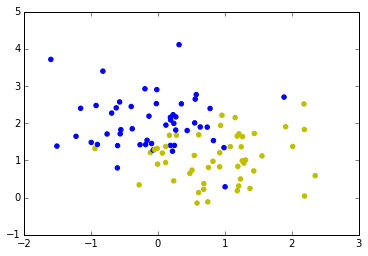

In [2]:
colors = np.array(['b', 'y'])
X, y = datasets.make_blobs(n_samples=100, centers=[[0, 2], [1, 1]], cluster_std=0.7)
data = Orange.data.Table(X, y)
plt.scatter(X[:, 0], X[:, 1], color=colors[y], s=20);

Implementacija, skladna z klasifikatorjem v okolju Orange.

In [3]:
def add_ones(X):
    return np.column_stack((np.ones(len(X)), X))
    
class SVMLearner(Orange.classification.Learner):
    def __init__(self, C=1):
        super().__init__()
        self.C = C
        self.name = "svm"
        
    def J_grad(self, thetas):
        z = self.y * self.X.dot(thetas)
        J = self.C * np.sum(np.maximum(0, 1 - z)) + np.sum(thetas**2)/2
        grad = thetas + self.C * np.sum(self.yx[z<1], axis=0)  
        return J, grad

    def J(self, thetas):
        return self.C * np.sum(np.maximum(0, 1 - self.y * self.X.dot(thetas))) + np.sum(thetas**2)/2

    def grad_approx(self, thetas, e=1e-1):
        return np.array([(self.J(thetas+eps) - self.J(thetas-eps))/(2*e)
                         for eps in np.identity(len(thetas)) * e])

    def grad(self, thetas):
        z = self.y * self.X.dot(thetas)
        return thetas + self.C * np.sum(self.yx[z<1], axis=0)

    def fit_storage(self, data):
        self.X, y = add_ones(data.X), np.copy(data.Y)
        self.scaler = StandardScaler().fit(self.X)
        self.X = self.scaler.transform(self.X)
        self.y = (y-0.5) * 2
        self.yx = - self.y[:, None] * self.X
        thetas = np.random.rand(self.X.shape[1]) * 0.01
        
        thetas, fmin, info = fmin_l_bfgs_b(self.J_grad, thetas)

        self.info = info
        self.thetas = thetas
        return SVMModel(thetas, self.scaler)

    def grad_test(self):
        self.X, self.y = datasets.make_blobs(n_samples=100, centers=[[0, -4], [1, 1]], cluster_std=0.7)
        thetas = np.random.rand(self.X.shape[1]) * 0.01
        self.yx = - self.y[:, None] * self.X
        print(self.grad_approx(thetas))
        print(self.grad(thetas))

class SVMModel(Orange.classification.Model):
    """Classifier for gradient boosting."""
    def __init__(self, thetas, scaler):
        self.thetas = thetas
        self.scaler = scaler
    
    def predict(self, X):
        """Given a data instance or table of data instances returns predicted class."""
        X = scaler.transform(add_ones(X))
        return 0

Test in izris odločitvene meje. Slednji je preprost, saj z implementirano tehniko neposredno poiščemo njeno normalo in sečišče osi y.

In [4]:
svm = SVMLearner(C=0.1)
x = svm(data)
x.thetas

array([ 0.00379885,  0.81599527, -0.87174073])

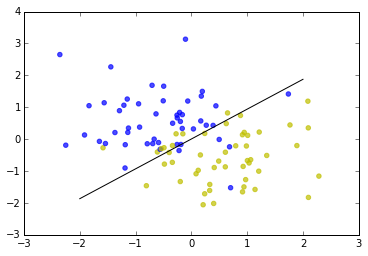

In [5]:
X = svm.X
y = svm.y
plt.scatter(X[:, 1], X[:, 2], color=colors[((y+1)/2).astype(int)], s=20, alpha=0.7)
x1 = np.array([-2, 2])
x2 = (-svm.thetas[0] - svm.thetas[1] * x1) / svm.thetas[2]
plt.plot(x1, x2, c="k");